In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prophet

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 300)

In [26]:
df = pd.read_csv('./data/raw/sales_train_validation.csv')

In [4]:
df

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,...,d_1664,d_1665,d_1666,d_1667,d_1668,d_1669,d_1670,d_1671,d_1672,d_1673,d_1674,d_1675,d_1676,d_1677,d_1678,d_1679,d_1680,d_1681,d_1682,d_1683,d_1684,d_1685,d_1686,d_1687,d_1688,d_1689,d_1690,d_1691,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,2,0,2,2,0,0,0,1,1,0,2,0,1,1,2,0,1,0,0,0,2,1,0,1,1,2,0,0,0,0,0,0,0,1,0,1,0,1,0,3,1,1,0,1,1,2,0,0,0,0,1,1,0,0,0,0,3,0,1,0,0,0,0,1,1,1,0,1,0,2,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,2,0,0,1,1,1,1,0,0,0,0,0,1,2,2,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,3,0,1,2,1,0,3,0,0,0,1,0,2,2,1,0,0,1,2,0,1

In [6]:
df['store_id'].value_counts()

CA_4    3049
CA_1    3049
WI_3    3049
CA_3    3049
CA_2    3049
WI_2    3049
TX_2    3049
TX_1    3049
WI_1    3049
TX_3    3049
Name: store_id, dtype: int64

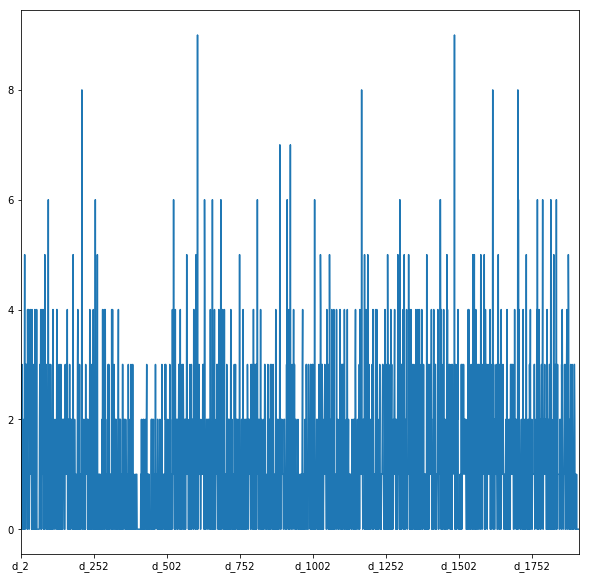

In [7]:
df.iloc[312,7:].plot(figsize = (10,10))

In [28]:
sampsub = pd.read_csv('./data/raw/sample_submission.csv')

In [9]:
quantiles_to_predict = [0.005, 0.025, 0.165, 0.25, 0.5, 1-0.25, 1-0.165, 1-0.025, 1-0.005]
quantiles_to_predict

[0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

In [43]:
def build_item_model(item_id, dept_id, cat_id, store_id, state_id):
    identifier = '{}_{}_validation'.format(item_id, store_id)
    item_data = df[df['id'] == identifier].melt(id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id','state_id']).drop('variable', axis = 1)
    
    #model
    quantiles_to_predict = [0.005, 0.025, 0.165, 0.25, 0.5, 1-0.25, 1-0.165, 1-0.025, 1-0.005]
    quantiles = item_data['value'].quantile(quantiles_to_predict)
    
    forecast_cols = ['F{}'.format(i) for i in np.arange(1,29)]
    extra_id_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'quantile', 'sub_id']
    
    
    sub = pd.DataFrame(columns = extra_id_cols + forecast_cols)
    
    
    for q in quantiles_to_predict:
        sub_row_id = '{}_{}_{:.3f}_{}'.format(item_id, store_id, q, 'validation')
        #fetch from model
        sub.loc[sub_row_id, forecast_cols] = quantiles[q]
        sub.loc[sub_row_id, 'quantile'] = "{:.3f}".format(q)
        sub.loc[sub_row_id, 'sub_id'] = 'validation'
        sub_row_id = '{}_{}_{:.3f}_{}'.format(item_id, store_id, q, 'evaluation')
        #fetch from model
        sub.loc[sub_row_id, forecast_cols] = quantiles[q]
        sub.loc[sub_row_id, 'quantile'] = "{:.3f}".format(q)
        sub.loc[sub_row_id, 'sub_id'] = 'evaluation'
    
    sub['item_id'] = item_id
    sub['dept_id'] = dept_id
    sub['cat_id'] = cat_id
    sub['store_id'] = store_id
    sub['state_id'] = state_id
    return(sub)

In [44]:
build_item_model(item_id = 'HOBBIES_1_001', dept_id = 'HOBBIES_1', cat_id = 'HOBBIES', store_id = 'CA_1', state_id = 'CA')

,item_id,dept_id,cat_id,store_id,state_id,quantile,sub_id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
HOBBIES_1_001_CA_1_0.005_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0.005,validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
HOBBIES_1_001_CA_1_0.005_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0.005,evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
HOBBIES_1_001_CA_1_0.025_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0.025,validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
HOBBIES_1_001_CA_1_0.025_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0.025,evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
HOBBIES_1_001_CA_1_0.165_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0.165,validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
HOBBIES_1_001_CA_1_0.165_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0.165,evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
HOBBIES_1_001_CA_1_0.250_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0.250,validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
HOBBIES_1_001_CA_1_0.250_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0.250,evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
HOBBIES_1_001_CA_1_0.500_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0.500,validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
HOBBIES_1_001_CA_1_0.500_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0.500,evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
from tqdm import tqdm

In [ ]:
sub_df = pd.DataFrame()
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    sub_df = pd.concat([sub_df, build_item_model(row['item_id'], row['dept_id'], row['cat_id'], row['store_id'], row['state_id'])])
    



  0%|          | 0/30490 [00:00<?, ?it/s]

  0%|          | 1/30490 [00:01<11:18:37,  1.34s/it]

  0%|          | 4/30490 [00:01<8:01:08,  1.06it/s] 

  0%|          | 7/30490 [00:01<5:42:57,  1.48it/s]

  0%|          | 10/30490 [00:01<4:06:19,  2.06it/s]

  0%|          | 13/30490 [00:01<2:58:34,  2.84it/s]

  0%|          | 16/30490 [00:01<2:11:10,  3.87it/s]

  0%|          | 19/30490 [00:02<1:37:36,  5.20it/s]

  0%|          | 22/30490 [00:02<1:14:33,  6.81it/s]

  0%|          | 25/30490 [00:02<58:36,  8.66it/s]  

  0%|          | 28/30490 [00:02<47:22, 10.72it/s]

  0%|          | 31/30490 [00:02<39:16, 12.93it/s]

  0%|          | 34/30490 [00:02<33:32, 15.14it/s]

  0%|          | 37/30490 [00:02<29:32, 17.18it/s]

  0%|          | 40/30490 [00:02<27:39, 18.35it/s]

  0%|          | 43/30490 [00:03<26:33, 19.11it/s]

  0%|          | 46/30490 [00:03<26:01, 19.50it/s]

  0%|          | 49/30490 [00:03<25:28, 19.91it/s]

  0%|          | 52/30490 [00:03<24:52, 20.40it/s]

  